In [4]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [5]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical linear regression


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical regression

* Hierarchical  regression is  a generalization of linear regression, which allows the  parameters to **vary by group**.


* This allows modelling observations which are  *grouped*  (or *clustered*). 

# Hierarchical (or multilevel) modeling

A *hierarchical regression* provides a compromise between:

* the *pooled regression*, which fits a single regression by merging all observations; this is  excessively constrained; 


* the *unpooled regression*, which fits an independent regression for each cluster.  This is unreliable on cluster containing few observations and there is no generalization to unobserved groups.

# The radon data set (Gelman et al., 2007)

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon data set (Gelman et al., 2007)



* Radon  is a radioactive gas; it is  the highest cause of lung cancer in non-smokers.



* Its level is  generally higher in the basement; moreover, its presence depends on the  type of soil.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota.


* For each measure we know:
    * the floor (basement or  first floor) 
    * the county (think of a county as a region)

### Data organization

In [6]:
# Import radon data, 919 rows
radon_data = pd.read_csv('data/radon.csv', index_col=0)

 
# Below we generate the standardized X and Y ( floor_std ,  log_radon_std) and for each measure
# a numerical index represeting  the county . There is a different number of measures for each county.

#list of  counties in Minnesota (85 different counties)
counties = radon_data.county.unique()
n_counties = counties.shape[0]

# numerical id of the county of each measure (919 rows)
county = radon_data.county_code.values
# code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))

# explanatory variable: the floor: 0 (ground level) or 1 (first floor).
floor = radon_data.floor.values

# y 
log_radon = radon_data.log_radon.values

In [7]:
radon_data

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,Y,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.871802
915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,Y,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.526056
916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,Y,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.629241
917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,Y,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,27173.0,1.426590,84,1.335001


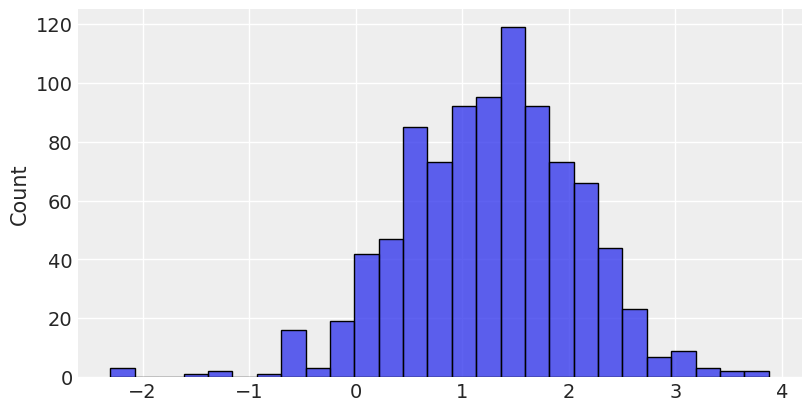

In [4]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

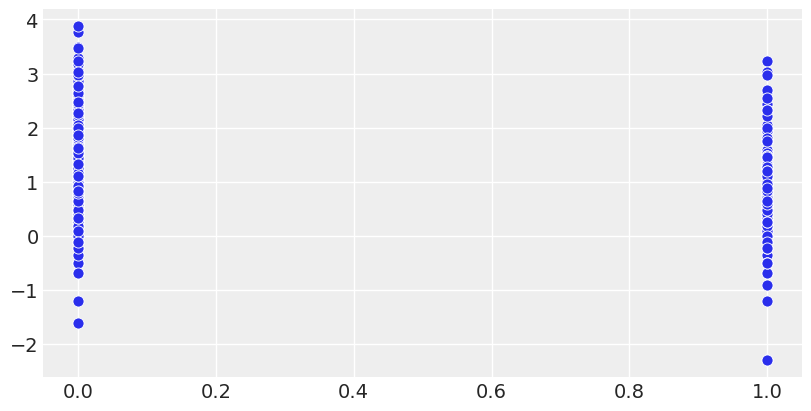

In [5]:
#as floor takes only 0 and 1 as values, we have data organized into two columns 
#The radon level is higher in the basement (floor = 0) than in the first floor (floor = 1).
sns.scatterplot(floor, log_radon);

# Pooled regression

A regression model which ignores the county:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: log-radon (919 measures)

* $X$: floor (1 or 0)

* $\alpha$ : intercept.  (on  centered data, it represents the mean log-radon in Minnesota). 


# Pooled regression 

* We use the centered covariate  $X_c = X - \bar{x}$


* We have no prior knowledge and thus we use fall back to  weakly informative, data-dependent, priors:

\begin{align}
Y  &\sim N( \alpha_c + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}

# Unpooled regression 


$$ Y \sim N( \alpha_{\text{county}[i]} + \beta X, \sigma) $$


* $\alpha_{\text{county}[i]}$ : the intercept for the county where the $i$-th observation has been made (think of  `county` as an array containing the county code of each measure)



*  For each county we have a different independent   intercept $\alpha_1, \alpha_2, .. \alpha_j ...\alpha_{85}$ 




# Unpooled regression


$$ Y \sim N( \alpha_{\text{county}[i]} + \beta X, \sigma) $$

* The slope $\beta$ is equal for all counties; we assume that the difference between floor and basement does not depend on the county.



# Unpooled regression

\begin{align}
Y  &\sim N( \alpha_{\text{county}} + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha_j &\sim N(\bar{y},2 s_y) \,\, j=1,2..., 85&& \text{prior on the intercept} \\
\beta & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\end{align}

# Discussion

* The pooled model assumes  all observations to be samples from the same process,  ignoring the  county.


* The unpooled model learns from scratch the intercept (baseline level) of every county, without transferring any information between the different counties.

# Implementation

In [6]:
#implementation of the pooled model

#centering is needed to have effective sampling
floor_c  = (floor - floor.mean())
mu_y    = log_radon.mean()
s_y        = log_radon.std()
s_x        = floor_c.std()

with pm.Model() as pooled_model:

    alpha  = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta    = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma = pm.HalfNormal('sigma', 1.5 * s_y)
    y          = pm.Normal('y', alpha + beta * floor_c, sigma, observed=log_radon)


In [7]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


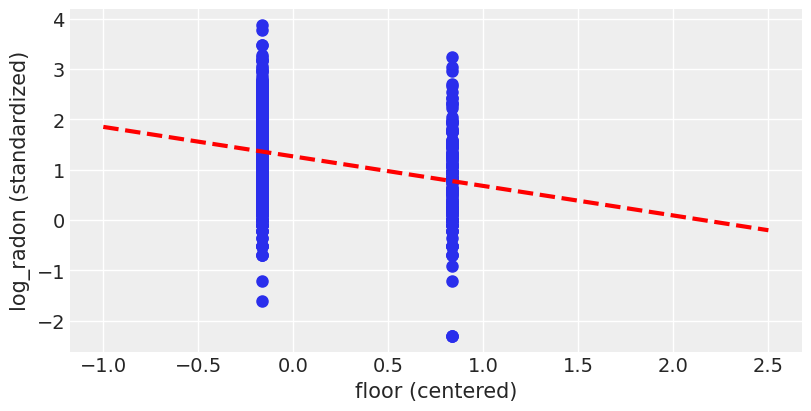

In [8]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(pooled_trace)
a_pooled      =  post_pooled.alpha.values.mean()
b_pooled      = post_pooled.beta.values.mean()

plt.scatter(floor_c, log_radon)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('floor (centered)')
plt.ylabel('log_radon (standardized)');

 # Implementing  the unpooled model

In [9]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=mu_y, sigma=2 * s_y, shape=n_counties)

    # the slope is the same for all counties
    beta           = pm.Normal('beta', mu=0, sigma=2 * s_y/s_x)
    sigma_y   = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[county] + beta * floor_c
    
    y = pm.Normal('y', mu, sigma=sigma_y, observed=log_radon)
    

In [10]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


## Comparing the pooled and unpooled model

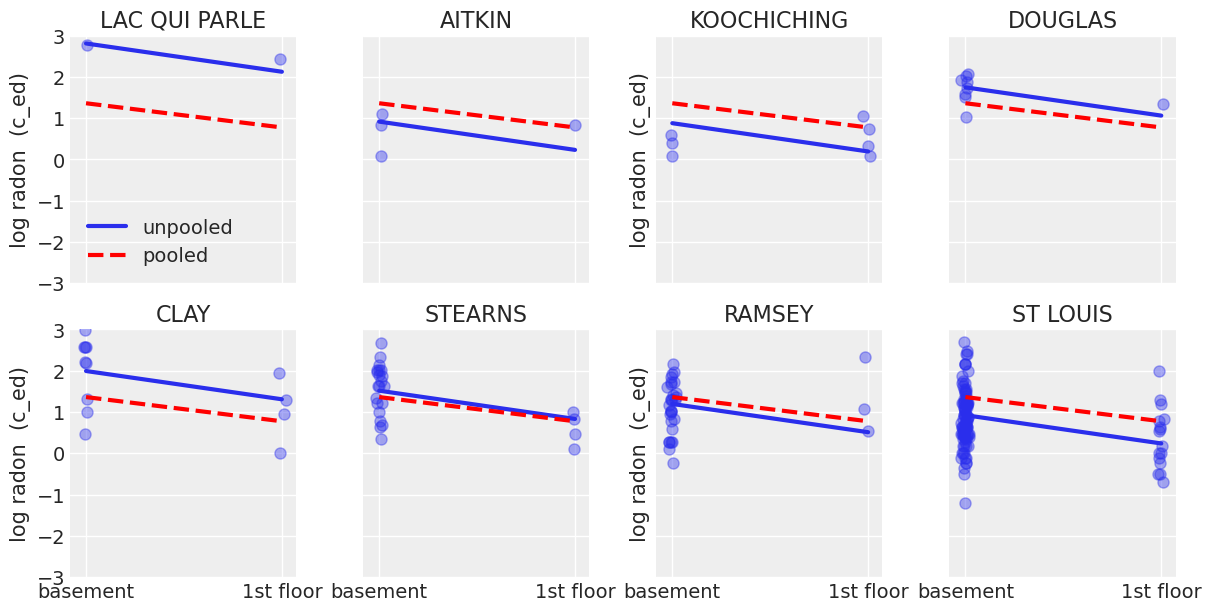

In [11]:
#The code below shows the pooled and unpooled model for some sample counties.
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

# intercept of the unpooled model (posterior mean): an array, one element for each county.
#alpha_unpooled = pd.Series(unpooled_trace['alpha'].mean(axis=0), index=counties)
alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=counties)

for i,c in enumerate(sample_counties):
    #select the subset of observation referring to the specific county
    y = log_radon[radon_data.county==c]
    x = floor_c[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(floor_c.min(), floor_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([floor_c.min(), floor_c.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (c_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled.png')

<img src='img/pooled_unpooled.png' width=1000 align="center" >

* The pooled model (red) is fixed and cannot  identify high-radon or low-radon counties

*  On the other hand, the  estimates of the unpooled models (blue)  for countries with few data, such as  LAC QUI PARLE,  are unreliable.

# Hierarchical regression


*   A different intercept for each county, modeling also the population of  intercepts.


* This is referred to as a  *varying intercept* model.


* Its estimates are a compromise between the unpooled and the pooled model.

# Hierarchical varying-intercept model

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_c,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,2  \frac{s_y}{s_x} )  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\end{align}

* Broad priors  on the parameters of the population of intercepts


* This is  a **varying-intercept** model, since the intercept is different for each county, while the slope is unique for  all counties.


In [12]:
with pm.Model() as hier_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a     = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[county] + beta * floor_c, sigma=sigma_y, observed=log_radon)    

In [13]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


## Partial pooling 

* The estimate of the hierarchical model is a compromise (*partial pooling*) between the pooled and unpooled model.

* Estimates for counties with few observations (or very spread observations) are pulled  towards the estimate of the pooled model (i.e., the state-wide average).

* For counties with many observations, the estimates  is closer to that of the  unpooled model.

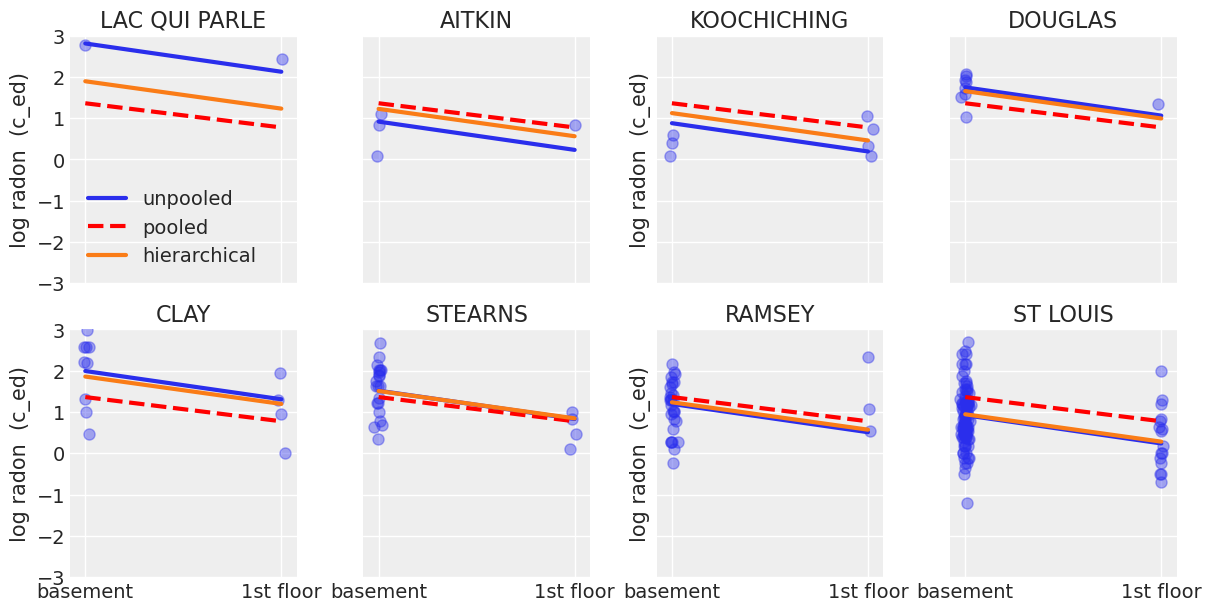

In [14]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier   = az.extract_dataset(hier_trace.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=counties)


for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = log_radon[radon_data.county==c]
    x = floor_c[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(floor_c.min(), floor_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[county_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[county_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([floor_c.min(), floor_c.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (c_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled_hier.png') 

#  The hierarchical model is a sensible compromise 

<img src='img/pooled_unpooled_hier.png' width=900 align="center" >

* Close to the unpooled model on data-rich counties.

* Close to the pooled model on data-poor counties.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [15]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,-1036.192592,48.672866,0.000000,9.297917e-01,27.907732,0.000000,True,log
unpooled,1,-1054.950330,79.920422,18.757738,1.210059e-15,28.370718,5.655189,True,log
pooled,2,-1090.062375,3.947581,53.869783,7.020827e-02,25.045747,10.690158,False,log


# Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group



# Your turn: compute predictive distributions


*  Compare the predictive distribution  for a floor measurement  for "lac qui parle", according to the unpooled and to  the varying-intercept hierarchical model.


 * Compute the  predictive distribution for a novel county using the  varying-intercept hierarchical model.



* Hint: the centered value of floor 0 is 0.16648531 (check np.unique(floor_c))


    

# Your turn: slope-varying, intercept-varying model

* Implement a model which treats  the slope and the intercept in a hierarchical way. 


* Compute the predictive distribution for "lac qui parle" and for a novel county.


* Compare the model against the previous one; which one would you choose?
    
    

# Solutions

In [16]:
#predictive distribution for a new measure in LAC QUI PARLE, according to the unpooled and the varying-intercept model
# Part 1

floor_0 = 0.16648531

#this value is obtained by 
#np.unique(floor_c)
#array([-0.16648531,  0.83351469])


#get the trace samples
post_hier    = az.extract_dataset(hier_trace.posterior)
post_unp    = az.extract_dataset(unpooled_trace.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values
beta_unp =  post_unp.beta.values

#samples of the intercept for LAC 
alpha_lac_hier = post_hier.alpha.values[county_lookup['LAC QUI PARLE']] 
alpha_lac_unp = post_unp.alpha.values[county_lookup['LAC QUI PARLE']] 

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values
sigma_y_unp =  post_unp.sigma_y.values

In [17]:
#Part 2 - computing the predictive based on the samples from the trace
y_new_hier = np.zeros(len(beta_hier))
y_new_unp = np.zeros(len(beta_unp))

#this could be easily vectorized. I leave the for loop mainly for clarity
for i, current_mu in enumerate(beta_hier):
        #to have a more precise quantification, we could generate more than one values   with the i-th sample of parameters.
        # that is how pymc3 implements the predictive checks.
        y_new_hier[i] = np.random.normal (loc = alpha_lac_hier[i] + beta_hier[i] *  floor_0 , scale = sigma_y_hier[i])
        y_new_unp[i] = np.random.normal (loc = alpha_lac_unp[i] + beta_unp[i] *  floor_0 , scale = sigma_y_unp[i])

#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
a=  pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unp).describe()
c =  pd.concat ([a,b], axis=1)
c.columns = ['hier', 'unpooled']
c

,hier,unpooled
count,4000.000000,4000.000000
mean,1.658675,2.567901
std,0.775077,0.898137
min,-1.178113,-0.320255
25%,1.149703,1.967836
50%,1.669439,2.584774
75%,2.175448,3.176421
max,4.344777,5.426219


In [23]:
# predictive distribution for a measure taken in a new county.
# This is not possible with the unpooled model.
# Part 1 

post_hier    = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

#for i, current_mu in enumerate(mu_a):
 #   alpha_new[i] = np.random.normal (loc = mu_a[i], scale = sigma_a[i])

#vectorized implementation is more elegant, but equivalent to the loop above
alpha_new = np.random.normal (loc = mu_a, scale = sigma_a)

 #samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [24]:
# predictive distribution for a measure taken in a new county.
# Part 2 
        
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,4000.000000
mean,1.285239
std,0.800339
min,-1.844501
25%,0.760300
50%,1.275225
75%,1.816677
max,4.360914


# Varying-slope and varying-intercept model

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_c,  \sigma) && \text{likelihood} \\
\\
\beta_j &\sim N(\mu_{\beta}, \sigma_{\beta}) \,\, j=1,2..., 85&& \text{population of slopes} \\
\mu_{\beta} &\sim N(0,10 s_y)  && \text{prior on the mean slope} \\
\sigma_{\beta} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of slopes}\\
\\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\end{align}

In [19]:
with pm.Model() as varying_slope_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a     = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # Population of slopes
    mu_b      = pm.Normal('mu_b', mu=0, sigma=10 * s_y)
    sigma_b = pm.HalfNormal('sigma_b', 5 * s_y)
    beta         = pm.Normal('beta', mu=mu_b, sigma= sigma_b)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[county] + beta * floor_c, sigma=sigma_y, observed=log_radon)    

In [20]:
with varying_slope_model:
    varying_slope_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, sigma_b, mu_b, alpha, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 355 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6125272727551778, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
# the varying slope is ranked second
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace, 'varying_slope':varying_slope_trace}, ic='waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,-1036.192592,48.672866,0.000000,0.929748,27.907732,0.000000,True,log
varying_slope,1,-1037.586556,50.255175,1.393965,0.000000,28.108220,0.506762,True,log
unpooled,2,-1054.950330,79.920422,18.757738,0.000000,28.370718,5.655189,True,log
pooled,3,-1090.062375,3.947581,53.869783,0.070252,25.045747,10.690158,False,log


In [22]:
# predictive distribution for lac qui parle
#get the trace samples
post_hier_vt    = az.extract_dataset(varying_slope_trace.posterior)

#samples of the intercept for LAC 
alpha_lac_vt = post_hier_vt.alpha.values[county_lookup['LAC QUI PARLE']] 


#samples of the slope for LAC
beta_lac_vt = post_hier_vt.beta.values[county_lookup['LAC QUI PARLE']] 


#samples of sd
sigma_y_vt =  post_hier_vt.sigma_y.values

y_new_vt = np.zeros(len(alpha_lac_vt))
y_new_vt = np.random.normal (loc = alpha_lac_vt + beta_lac_vt *  floor_0 , scale = sigma_y_vt)

pd.DataFrame(y_new_vt).describe()

,0
count,4000.000000
mean,1.688842
std,0.777811
min,-1.329433
25%,1.174702
50%,1.693885
75%,2.208589
max,4.343311
